### Author: Hoang Chu

#### Imports

In [1]:
%pip install -r dependencies.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import requests

In [3]:
import importlib
import helper, consts

In [4]:
importlib.reload(consts)
importlib.reload(helper)

<module 'helper' from '/Users/hoangchu/Documents/Clinic/code/helper.py'>

#### CONSTANTS

In [5]:
ROW_AX = 0
COL_AX = 1

In [6]:
DATA_PATH = consts.DATA_PATH
DATA_PATH

'../data/'

In [7]:
RESPONSE_NAME = "rel2retcfrtxm_nt_0"
PREDICTOR_NAME = 'rrirpnxm_nt_0'

#### Data Exploration

In [8]:
# local read

data_20191202_1200_df = pd.read_csv(DATA_PATH + "data_20191202_1200.csv")

In [9]:
# cloud read -- TODO: NEED A PERMANET LINK!!

# importlib.reload(consts)

# url = ... # url in consts.py
# assert requests.get(url).status_code == 200
# data_20191202_1200_df = pd.read_csv(url)
# data_20191202_1200_df.head()

In [10]:
working_df = data_20191202_1200_df.copy() # Deep copy

In [11]:
sorted_columns = sorted(working_df.columns)
len(sorted_columns)

252

In [12]:
predictor_column = working_df[PREDICTOR_NAME]
response_column = working_df[RESPONSE_NAME]

Text(0, 0.5, 'Response')

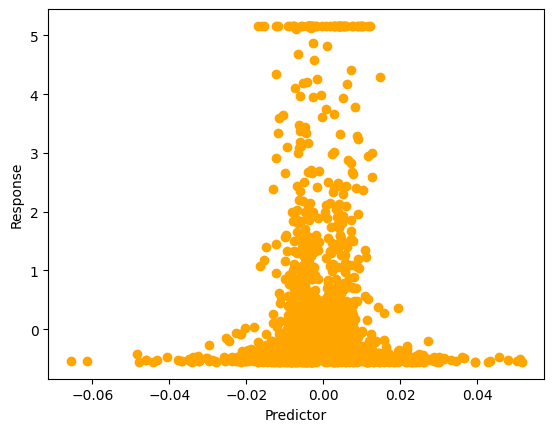

In [13]:
plt.scatter(x=working_df[[PREDICTOR_NAME]], y=response_column, color="orange")
plt.xlabel("Predictor")
plt.ylabel("Response")

#### Split data to train (80%) and test (20%)

In [14]:
# Build a train mask and test mask
np.random.seed(42)
data_size = working_df.shape[0]
testing_fraction = 0.2
testing_size = int(data_size * testing_fraction)

testing_indices = np.random.choice(np.arange(data_size), testing_size)
testing_mask = np.zeros(data_size, dtype = bool)
testing_mask[testing_indices] = True

training_mask = ~testing_mask # if testing_mask[i] = True, training_mask[i] = False

In [15]:
working_df['train_mask'] = training_mask
working_df['test_mask'] = testing_mask

In [16]:
training_condition = (working_df['train_mask'] == True)
training_df = working_df[training_condition][[PREDICTOR_NAME]].reset_index(drop=True)
training_target_series = working_df[training_condition][RESPONSE_NAME].reset_index(drop=True)
assert training_df.shape[0] == len(training_target_series)

training_df.head()

,rrirpnxm_nt_0
0,0.015402
1,-0.006332
2,0.001978
3,0.000035
4,0.004667


In [17]:
testing_condition = (working_df['test_mask'] == True)
testing_df = working_df[testing_condition][[PREDICTOR_NAME]].reset_index(drop=True)
testing_target_series = working_df[testing_condition][RESPONSE_NAME].reset_index(drop=True)
assert testing_df.shape[0] == len(testing_target_series)

testing_df.head()

,rrirpnxm_nt_0
0,0.005125
1,0.003413
2,-0.001960
3,-0.000405
4,-0.001259


#### Build a simple (1-variable) linear regression model

##### Retrieve the beta

In [18]:
import sklearn.linear_model

simple_linreg = sklearn.linear_model.LinearRegression()
simple_linreg.fit(training_df, training_target_series) # Least Square Method
simple_linreg.coef_

array([1.3475641])

##### Make prediction

In [19]:
predicted_responses = simple_linreg.predict(testing_df)

#### Model evaluation

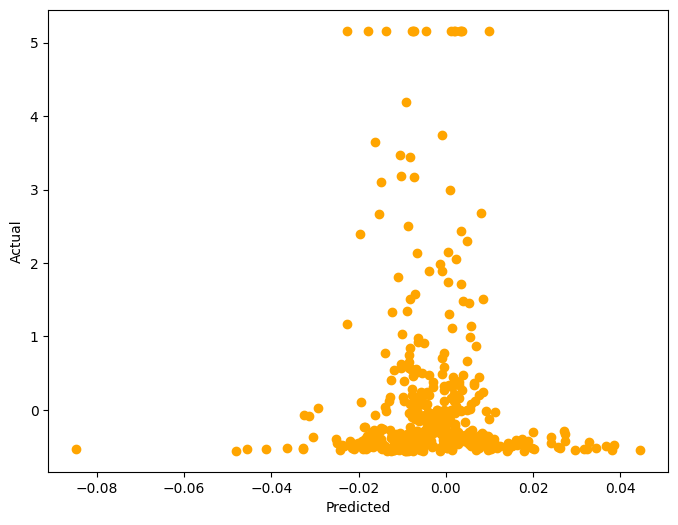

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(y=testing_target_series, x=predicted_responses, color='orange')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
mse = mean_squared_error(testing_target_series, predicted_responses)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.2407019226895841


In [23]:
# Higher better. 1 is perfect prediction
r_squared = r2_score(testing_target_series, predicted_responses)
print(f"R-Squared: {r_squared}")

R-Squared: -0.007769543877188312


In [24]:
residuals = testing_target_series - predicted_responses

#### Check linear regression assumptions

##### Residuals must be normally distributed w/ Q-Q plot

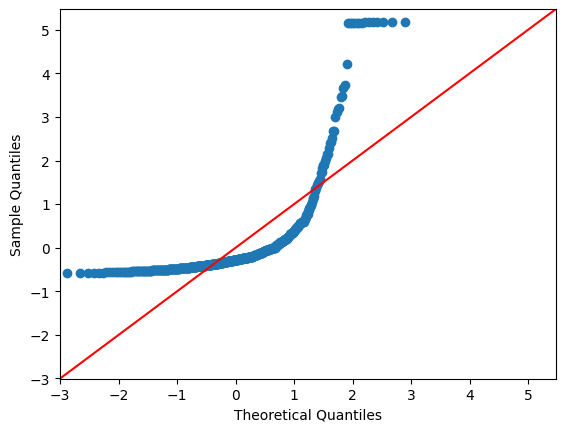

In [25]:
import statsmodels.api as sm

sm.qqplot(np.array(residuals), line = '45'); # A semicolon to avoid 2 similar plots -- this has been the library's bug for 5 years!

In [26]:
helper.shapiro_test(residuals)

Shapiro-Wilk Test: Residuals NOT normally distributed.


##### Mean of residuals should be 0

In [27]:
np.mean(residuals)

0.09107938559662897

##### Check for multi-collinearity

In [28]:
helper.vif_test(r_squared)

VIF = 0.9922903565359829. This model performs worse than a horizontal line :(


##### Residuals have a fixed variance

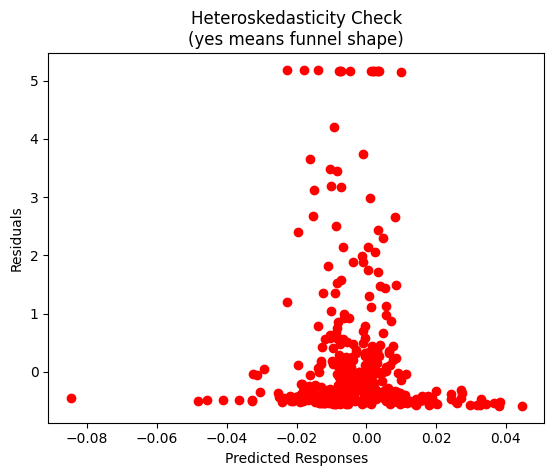

In [29]:
plt.scatter(x=predicted_responses, y = residuals, color = 'r')  # Replace X[:, 0] with the desired predictor variable
plt.xlabel('Predicted Responses')  # Replace 'X' with the label of the predictor variable
plt.ylabel('Residuals')
plt.title('Heteroskedasticity Check\n(yes means funnel shape)')
plt.show()

In [30]:
# White test if only use 1 predictor (simple linear regression)
# for multiple linear regression, use bp-test

helper.white_test(residuals, testing_df)

White Test: Residuals DO NOT have constant variance.


In [31]:
%pip freeze > dependencies.txt

Note: you may need to restart the kernel to use updated packages.
